本notebook用于用cifar10的小图来合成大图

In [1]:
#导包
import pickle
from tqdm import tqdm

from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def unpickle(file):
    """cifar10数据官方提供的导入代码"""
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
#参数配置
portrait_path=r'liuyifei.jpeg'

block=5

#小图
cifar10_path=r'D:\PythonCode\otherCodes\data\cifar-10-batches-py'
cifar10_file_names=[r'\data_batch_'+str(i) for i in range(1,6)]
cifar10_file_names.append(r'\test_batch')

cifa10_avgcolor_folder=r"D:\PythonCode\otherCodes\data\cifar10-avgcolor"

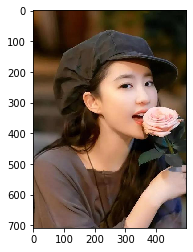

In [4]:
#展示原图
portrait_picture=Image.open(portrait_path)
plt.imshow(portrait_picture)

In [5]:
#将图片转换为np.ndarray
portrait_matrix=portrait_picture.convert("RGB")
portrait_ndarray = np.array(portrait_matrix)

In [6]:
%%time
#将小图的RGB加载到内存中
little_rgbs={}
for file_name in cifar10_file_names:
    with open(cifa10_avgcolor_folder+"\\"+file_name+'_r') as f:
        little_rgbs[file_name+'_r']=f.readlines()
    with open(cifa10_avgcolor_folder+"\\"+file_name+'_g') as f:
        little_rgbs[file_name+'_g']=f.readlines()
    with open(cifa10_avgcolor_folder+"\\"+file_name+'_b') as f:
        little_rgbs[file_name+'_b']=f.readlines()

Wall time: 40.4 ms


In [7]:
#将小图的batch加载到内存中
cifar10_batches=[]
for file_name in cifar10_file_names:  #遍历所有batch
    cifar10_batch=cifar10_path+file_name  #该batch对应的路径
    cifar10_batches.append(unpickle(cifar10_batch)[b'data'])

In [8]:
cifar10_batches[5].dtype

dtype('uint8')

In [9]:
def convert_smalls_to_big(block_dim:int):
    """
    将一堆小图转换为大图，入参为大图色块的维度，返回新图
    """
    old_shape=portrait_ndarray.shape
    heng_dim=int(old_shape[0]/block_dim)
    zong_dim=int(old_shape[1]/block_dim)
    new_picture=np.ndarray(shape=(heng_dim*32,zong_dim*32,3),dtype=np.int16)
    for i in range(heng_dim):
        for j in range(zong_dim):
            old_matrix=portrait_ndarray[i*block_dim:(i+1)*block_dim,j*block_dim:(j+1)*block_dim,:]
            r=np.mean(old_matrix[:,:,0])
            g=np.mean(old_matrix[:,:,1])
            b=np.mean(old_matrix[:,:,2])
            
            least_distance=450  #理论最大值应该是np.sqrt(255*255+255*255+255*255)≈442
            least_distance_batch_index=0
            least_distance_picture_index=0
            
            for index in range(6):
                #遍历每一个batch
                for picture_index in range(len(cifar10_batches[index])):
                    #遍历每一张图
                    little_r=float(little_rgbs[cifar10_file_names[index]+'_r'][picture_index])
                    little_g=float(little_rgbs[cifar10_file_names[index]+'_g'][picture_index])
                    little_b=float(little_rgbs[cifar10_file_names[index]+'_b'][picture_index])
                    distance=np.sqrt((little_r-r)**2+(little_g-g)**2+(little_b-b)**2)
                    if distance<least_distance:
                        least_distance=distance
                        least_distance_batch_index=index
                        least_distance_picture_index=picture_index
            little_picture=cifar10_batches[least_distance_batch_index][least_distance_picture_index]
            new_picture[i*32:(i+1)*32,j*32:(j+1)*32,0]=np.reshape(little_picture[:1024],(32,32)).copy()
            new_picture[i*32:(i+1)*32,j*32:(j+1)*32,1]=little_picture[1024:2048].reshape(32,32)
            new_picture[i*32:(i+1)*32,j*32:(j+1)*32,2]=little_picture[2048:].reshape(32,32)
    plt.imshow(new_picture)
    plt.savefig("picture1.png")

Wall time: 1h 23min 27s


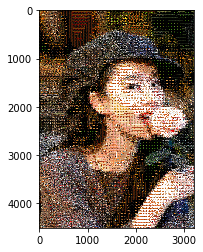

In [10]:
%%time
convert_smalls_to_big(block)